In [1]:
%precision 3

import numpy as np
import pandas as pd
from dtw import *
from matplotlib import pyplot as plt
from matplotlib import ticker
plt.style.use("minimal")

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [322]:
session = 4
datafile_path = f"data/Test{session}.tsv"

metadata_header_lines = 9

events = pd.read_csv(datafile_path, sep = "\t", header = None, names = ("Type", "Name", "Frame", "Time"), skiprows=metadata_header_lines, on_bad_lines = "skip").drop(columns = ["Type"])

amount_trials = 1 + len(events[events["Name"] == "Trial"])
print(f"""[INFO] found {amount_trials} trial{"s" if amount_trials > 1 else ""}""")

marker_names = pd.read_csv(datafile_path, sep = "\t", header = None, skiprows=metadata_header_lines + len(events), nrows = 1).loc[0, 1:].values
markers = list(sorted(set([name[2:] for name in marker_names])))
print(f"""[INFO] found {len(markers)} markers: {", ".join(markers)}""")

data = pd.read_csv(datafile_path, sep = "\t", header = metadata_header_lines + len(events) + 2, usecols=lambda name: "Unnamed" not in name)

position_cols = [col for col in data.columns if col not in ["Frame", "Time"]]
data[position_cols] = data[position_cols].replace(0, np.nan).interpolate()

data = data.set_index(["Frame", "Time"])
data.columns = data.columns.str.split("_", expand = True)
data = data.stack(0)
data.columns = data.columns.str.split(" ", expand = True)
data = data.stack(1)
data.index = data.index.rename(["Frame", "Time", "Subject", "Axis"])
data = data.reset_index()

for frame, event_name in events.set_index("Frame")["Name"].items():
    data.loc[data["Frame"] == frame, "Event"] = event_name

data.insert(2, "Trial", ((data["Event"] == "Trial") & (data["Event"].fillna(0) != data["Event"].fillna(0).shift())).cumsum() + 1)

position_cols = [col for col in data.columns if col not in ["Frame", "Time", "Trial", "Subject", "Axis", "Event"]]
data[position_cols] = data[position_cols].replace(0, np.nan)
# interpolated = data.copy()
# data.interpolated = interpolated

data

[INFO] found 4 trials
[INFO] found 8 markers: Biceps, Elbow, Hand, HipLeft, HipRight, ShoulderLeft, ShoulderRight, Wrist


,Frame,Time,Trial,Subject,Axis,Biceps,Elbow,Hand,HipLeft,HipRight,ShoulderLeft,ShoulderRight,Wrist,Event
0,1588,5.29000,1,A,X,NaN,NaN,-977.012,-925.306,-974.737,-958.759,NaN,-989.006,NaN
1,1588,5.29000,1,A,Y,NaN,NaN,-916.322,113.672,-295.125,22.374,NaN,-826.607,NaN
2,1588,5.29000,1,A,Z,NaN,NaN,1467.271,1081.677,1066.287,1601.823,NaN,1484.462,NaN
3,1588,5.29000,1,B,X,NaN,NaN,863.737,907.780,868.087,952.636,949.275,880.931,NaN
4,1588,5.29000,1,B,Y,NaN,NaN,606.231,-322.324,54.326,-262.484,-17.136,538.139,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51199,10121,33.73333,4,A,Y,-283.471,-331.337,-366.438,161.888,-260.837,119.443,-175.037,-367.938,NaN
51200,10121,33.73333,4,A,Z,1152.308,1089.059,867.753,1046.913,1013.384,1547.584,1568.448,946.776,NaN
51201,10121,33.73333,4,B,X,787.840,806.900,782.171,652.693,828.226,841.855,843.676,789.924,NaN
51202,10121,33.73333,4,B,Y,182.834,164.284,228.610,-272.180,153.257,-169.425,119.213,231.449,NaN


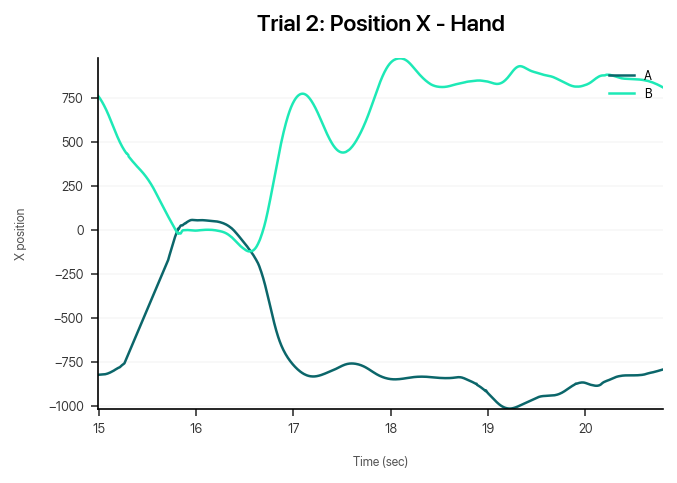

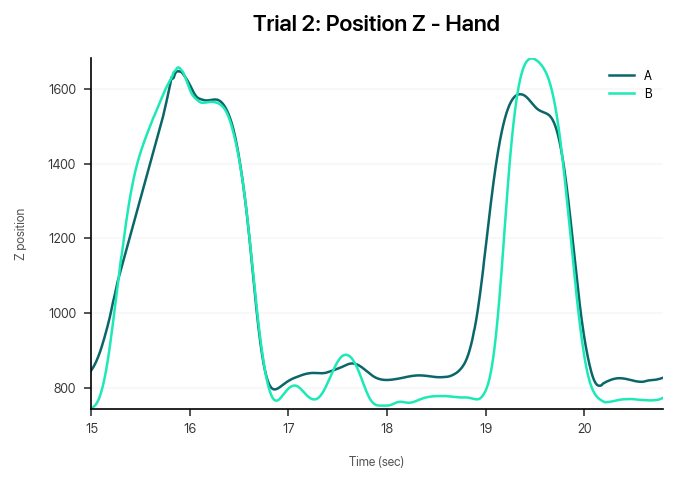

In [323]:
def plot_position(trial, marker, axis):
    plt.figure()
    for subject, subset in data[(data["Trial"] == trial) & (data["Axis"] == axis)].groupby("Subject"):
        plt.plot(
            subset["Time"], 
            subset[marker], 
            linewidth = 1.2, 
            label = subject, 
            color = dict(A = "C0", B = "C1")[subject]
        )
        # plt.plot(
        #     subset["Time"], 
        #     subset[marker].interpolate(), 
        #     linewidth = 1.2, 
        #     linestyle = ":", 
        #     color = dict(A = "C0", B = "C1")[subject]
        # )
    plt.margins(x = 0, y = 0)
    plt.title(f"Trial {trial}: Position {axis} - {marker}\n")
    plt.xlabel("Time (sec)")
    plt.ylabel(f"{axis} position")
    plt.legend(loc = "upper right")
    plt.tight_layout()

plot_position(trial = 2, marker = "Hand", axis = "X")
plot_position(trial = 2, marker = "Hand", axis = "Z")
# plot_position(trial = 1, marker = "Elbow", axis = "Z")

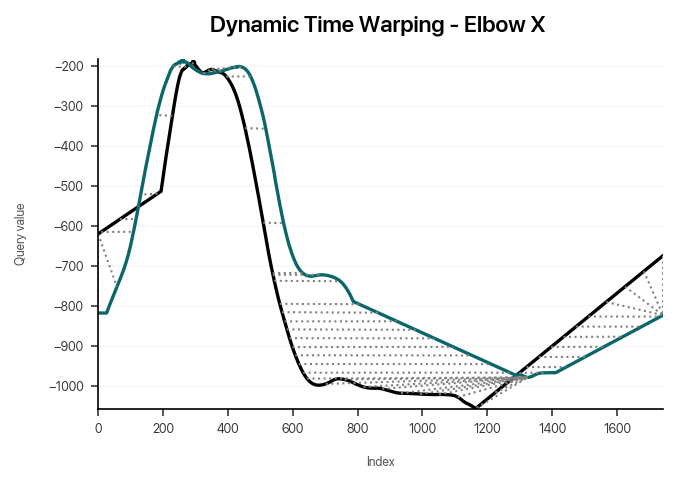

In [325]:
def plot_dtw(trial, marker, axis):
    subset = data[(data["Trial"] == trial) & (data["Axis"] == axis)].dropna(subset = marker)
    inverter = -1 if axis == "X" else 1
    data_A = subset[subset["Subject"] == "A"][marker].values
    data_B = inverter * subset[subset["Subject"] == "B"][marker].values
    dtw(data_A, data_B, keep_internals=True).plot(type = "twoway")
    plt.margins(x = 0, y = 0)
    plt.title(f"Dynamic Time Warping - {marker} {axis} \n")
    plt.tight_layout()

plot_dtw(trial = 2, marker = "Elbow", axis = "X")

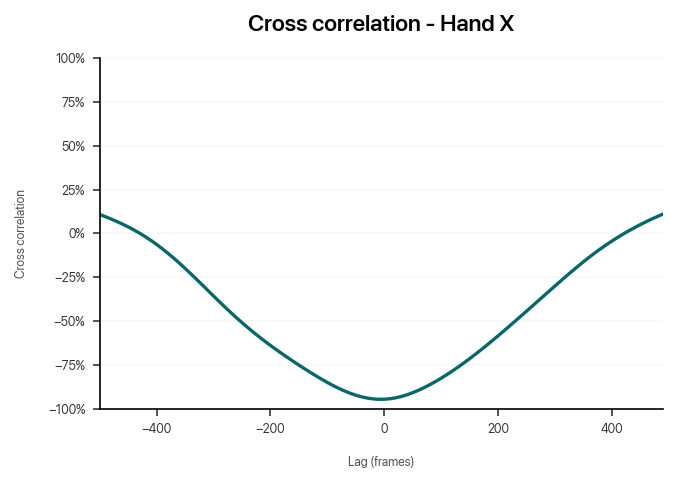

In [326]:
def plot_cross_correlation(trial, marker, axis, lags = np.arange(-500, 500, 10)):
    data_A = data[(data["Trial"] == trial) & (data["Axis"] == axis) & (data["Subject"] == "A")][marker].interpolate().reset_index(drop = True)
    data_B = data[(data["Trial"] == trial) & (data["Axis"] == axis) & (data["Subject"] == "B")][marker].interpolate().reset_index(drop = True)
    cross_corrs = [data_A.corr(data_B.shift(lag)) for lag in lags]
    plt.plot(lags, cross_corrs)
    plt.xlabel("Lag (frames)")
    plt.ylabel("Cross correlation")
    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))
    plt.title(f"Cross correlation - {marker} {axis}\n")
    plt.margins(x = 0, y = 0.1)
    plt.ylim((-1, 1))
    plt.tight_layout()

plot_cross_correlation(trial = 1, marker = "Hand", axis = "X")

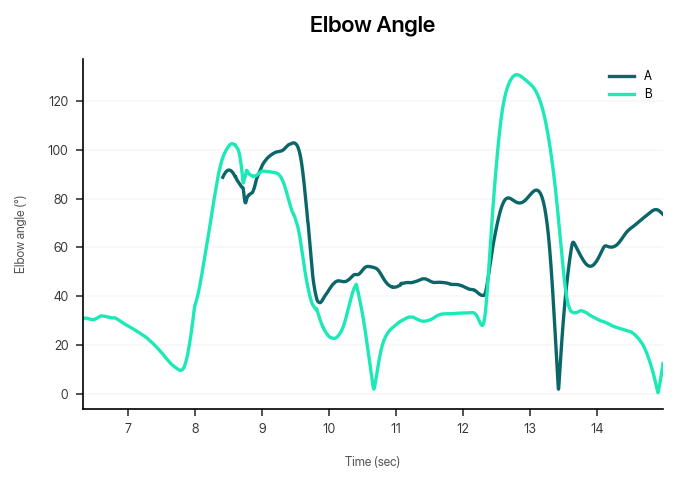

In [327]:
def calc_angles(data, markers):
    df = pd.DataFrame(index = data.index)
    df[["X1", "Y1", "Z1"]] = data[markers[0]].values - data[markers[1]].values
    df[["X2", "Y2", "Z2"]] = data[markers[1]].values - data[markers[2]].values

    line1 = df[["X1", "Y1", "Z1"]].divide(np.linalg.norm(df[["X1", "Y1", "Z1"]].values, axis=1), axis = 0)
    line2 = df[["X2", "Y2", "Z2"]].divide(np.linalg.norm(df[["X2", "Y2", "Z2"]].values, axis=1), axis = 0)

    df["Angle"] = np.degrees(np.arccos(np.clip(np.sum(line1.values * line2.values, axis = 1), -1, 1)))
    return df["Angle"]

def plot_angles(trial, markers):
    markers = list(markers)
    for participant in "AB":
        subset = data[(data["Trial"] == trial) & (data["Subject"] == participant)][["Time", "Axis"] + markers].pivot_table(
            index = "Time",
            columns = "Axis",
            values = markers,
        )
        plt.plot(calc_angles(subset, markers), label = participant)
    plt.title("Elbow Angle\n")
    plt.xlabel("Time (sec)")
    plt.ylabel("Elbow angle (°)")
    plt.margins(x=0)
    plt.legend()
    plt.tight_layout()

plot_angles(trial = 1, markers = ("ShoulderRight", "Elbow", "Hand"))